<img width="400" src="https://nomeroff.net.ua/images/logo/nomeroff_net.svg" alt="Nomeroff Net. Automatic numberplate recognition system" align="left"/>

## The example demonstrates license plate number detection.

Before runing this demo, please download models from [https://nomeroff.net.ua/models/](https://nomeroff.net.ua/models/) to **./models/** directory. 

In [1]:
# Import all necessary libraries.
import os
import cv2
import numpy as np
import sys
import json
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# change this property
NOMEROFF_NET_DIR = os.path.abspath('../')

# specify the path to Mask_RCNN if you placed it outside Nomeroff-net project
MASK_RCNN_DIR = os.path.join(NOMEROFF_NET_DIR, 'Mask_RCNN')
MASK_RCNN_LOG_DIR = os.path.join(NOMEROFF_NET_DIR, 'logs')

sys.path.append(NOMEROFF_NET_DIR)

Also you may use .pb models for options detectors or OCR detectors. 
More about conversion and preparing for inference withit https://github.com/ria-com/nomeroff-net/blob/master/examples/inference_convert.ipynb.

In [2]:
# Import license plate recognition tools.
from NomeroffNet import  filters, RectDetector, TextDetector, OptionsDetector, Detector, textPostprocessing, textPostprocessingAsync

# Initialize npdetector with default configuration file.
nnet = Detector(MASK_RCNN_DIR, MASK_RCNN_LOG_DIR)
nnet.loadModel("latest")

rectDetector = RectDetector()

optionsDetector = OptionsDetector()
optionsDetector.load("latest")

# Initialize text detector.
textDetector = TextDetector({
    "eu_ua_2004_2015": {
        "for_regions": ["eu_ua_2015", "eu_ua_2004"],
        "model_path": "latest"
    },
    "eu": {
        "for_regions": ["eu", "eu_ua_1995"],
        "model_path": "latest"
    },
    "ru": {
        "for_regions": ["ru", "eu-ua-fake-lnr", "eu-ua-fake-dnr"],
        "model_path": "latest" 
    },
    "kz": {
        "for_regions": ["kz"],
        "model_path": "latest"
    },
    "ge": {
        "for_regions": ["ge"],
        "model_path": "latest"
    }
})

Using TensorFlow backend.
W0708 18:44:28.522337 140026076382528 deprecation_wrapper.py:119] From /mnt/data/www/nomeroff-net/NomeroffNet/Detector.py:12: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0708 18:44:28.523528 140026076382528 deprecation_wrapper.py:119] From /mnt/data/www/nomeroff-net/NomeroffNet/Detector.py:14: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0708 18:44:29.214234 140026076382528 deprecation_wrapper.py:119] From /usr/local/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0708 18:44:29.220422 140026076382528 deprecation_wrapper.py:119] From /usr/local/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0708 18:44:29.228373 140026076382528 deprecation_wrapper.py:119] From /u

images/example1.jpeg


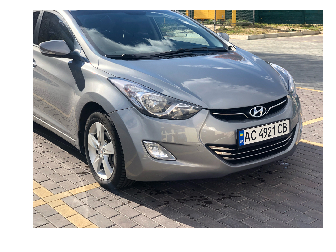

[[[ 872.          508.05882353]
  [1087.13941821  453.21936399]
  [1085.99178999  517.4865439 ]
  [ 872.          578.30526316]]]


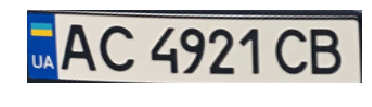

['eu_ua_2015']
[1]
['AC4921CB']
images/250030939.jpeg


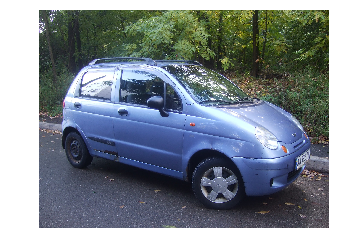

[[[1412.94959551  821.86058427]
  [1501.95247313  753.58440417]
  [1495.29120588  811.31538706]
  [1409.66116495  883.24462145]]]


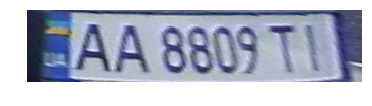

['eu_ua_2015']
[1]
['AA8809TI']
images/inx960x640.jpg


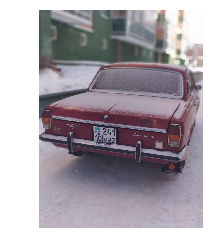

[[[285.08654742 611.75721229]
  [411.94255635 622.32854636]
  [413.14440398 719.67820478]
  [282.9288371  691.59249428]]]


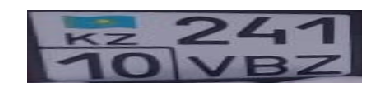

['kz']
[2]
['511C']
images/241458051.jpg


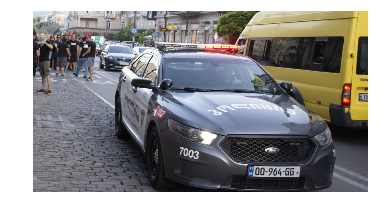

[[[642.43961346 461.95176186]
  [798.30902723 463.09786049]
  [795.77665025 496.01876115]
  [635.22475957 494.93395108]]]


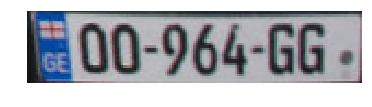

['ge']
[1]
['00964GG']
images/example2.jpeg


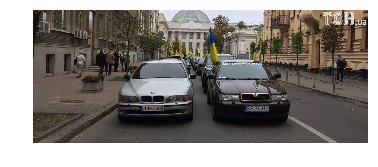

[[[526.70916711 379.94204426]
  [528.88562215 401.70659459]
  [426.05820226 403.02489484]
  [424.71512766 381.53570113]]

 [[948.         376.9375    ]
  [948.         404.        ]
  [843.         404.        ]
  [843.         380.21875   ]]]


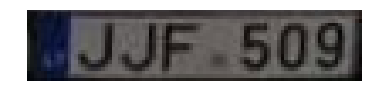

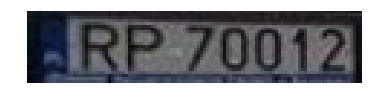

['eu', 'eu']
[1, 1]
['JJF509', 'RP70012']
images/20717578-39-full.jpg


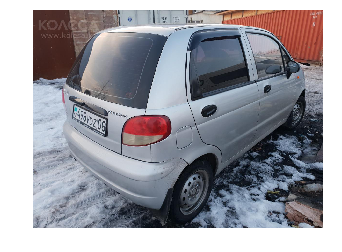

[[[167.88760018 388.00023825]
  [308.73849713 454.66249483]
  [303.03411947 518.55152463]
  [161.0311584  440.56629191]]]


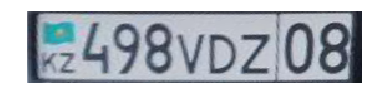

['kz']
[1]
['498VDZ08']


In [3]:
# Walking through the ./examples/images/ directory and checking each of the images for license plates.
rootDir = 'images/'

max_img_w = 1600
for dirName, subdirList, fileList in os.walk(rootDir):
    for fname in fileList:
        img_path = os.path.join(dirName, fname)
        print(img_path)
        img = mpimg.imread(img_path)
        plt.axis("off")
        plt.imshow(img)
        plt.show()
         
        # corect size for better speed
        img_w = img.shape[1]
        img_h = img.shape[0]
        img_w_r = 1
        img_h_r = 1
        if img_w > max_img_w:
            resized_img = cv2.resize(img, (max_img_w, int(max_img_w/img_w*img_h)))
            img_w_r = img_w/max_img_w
            img_h_r = img_h/(max_img_w/img_w*img_h)
        else:
            resized_img = img

        NP = nnet.detect([resized_img]) 
        
        # Generate image mask.
        cv_img_masks = await filters.cv_img_mask_async(NP)
            
        # Detect points.
        arrPoints = await rectDetector.detectAsync(cv_img_masks, outboundHeightOffset=0, fixGeometry=True, fixRectangleAngle=10)
        print(arrPoints)
        arrPoints[..., 1:2] = arrPoints[..., 1:2]*img_h_r
        arrPoints[..., 0:1] = arrPoints[..., 0:1]*img_w_r
        
        # cut zones
        zones = await rectDetector.get_cv_zonesBGR_async(img, arrPoints)
        toShowZones = await rectDetector.get_cv_zonesRGB_async(img, arrPoints)
        for zone, points in zip(toShowZones, arrPoints):
            plt.axis("off")
            plt.imshow(zone)
            plt.show()
    
        # find standart
        regionIds, stateIds, countLines = optionsDetector.predict(zones)
        regionNames = optionsDetector.getRegionLabels(regionIds)
        print(regionNames)
        print(countLines)

        # find text with postprocessing by standart  
        textArr = textDetector.predict(zones, regionNames, countLines)
        textArr = await textPostprocessingAsync(textArr, regionNames)
        print(textArr)